# Titanic Databse

First we need to do some basic imports.

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import os

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import MinMaxScaler

For this exercise, we will use the titanic dataset from kaggle. Since it is a csv file we need to write a function to opne the file in pandas

In [12]:
path_file = "Data/"

def loud_data(name, path=path_file):
    path = os.path.join(path, name)
    return pd.read_csv(path)

# Creating a Train and a Test Set

In [13]:
train = loud_data("train.csv")
test = loud_data("test.csv")
IDtest = test["PassengerId"]
PassengerId = test['PassengerId']
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


# Visualizing the Data

Make a copy to play with for visualization purposes

In [62]:
visual = dataset.copy()

There are many ways to visualize data. The easiest way to get a general sense is to look at the correlations with a pearson heat map

In [63]:
corr = visual.corr()

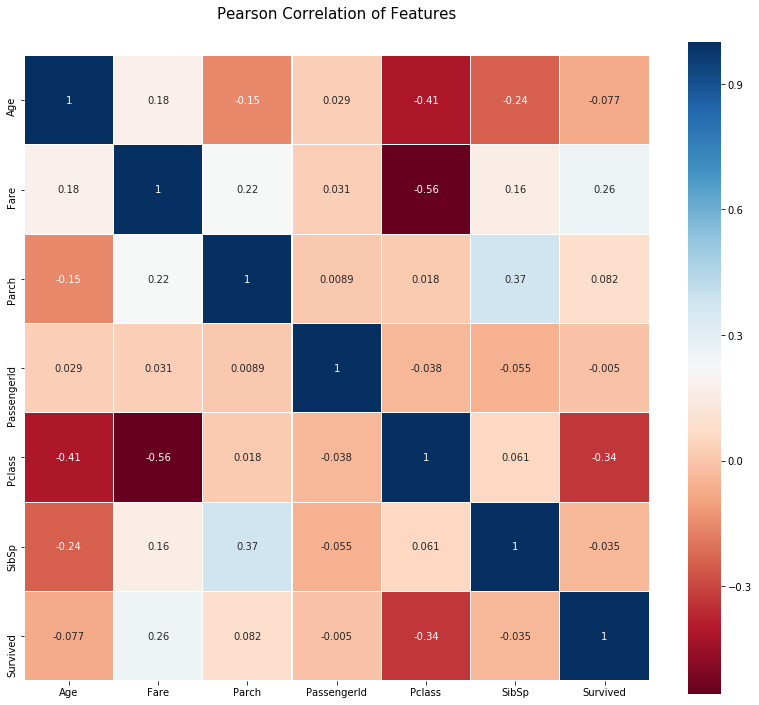

In [64]:
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corr,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

Let's further visualize subpopulations

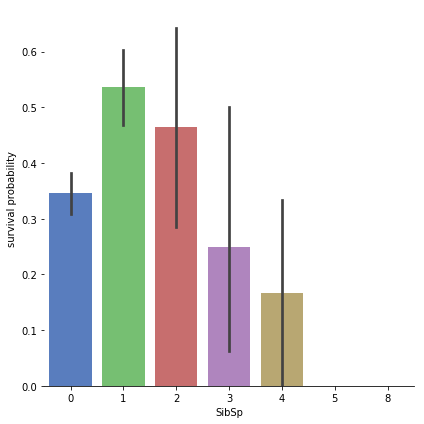

In [65]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

It seems that passengers that have a lot of sib and spouses on board have a low chance of survival, as well as those alone, but those w 1 or 2 seem to have a higher chance

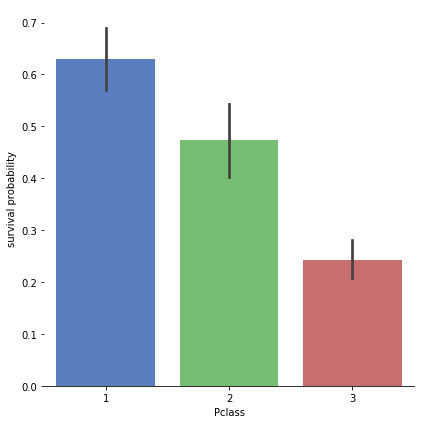

In [66]:
g = sns.factorplot(x="Pclass",y="Survived",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Class is clearly associated with survival

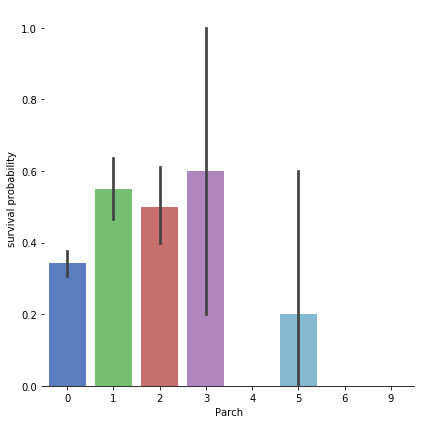

In [67]:
g = sns.factorplot(x="Parch",y="Survived",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

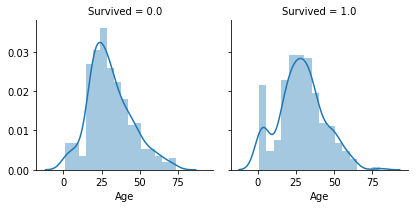

In [68]:
g = sns.FacetGrid(dataset, col='Survived')
g = g.map(sns.distplot, "Age")

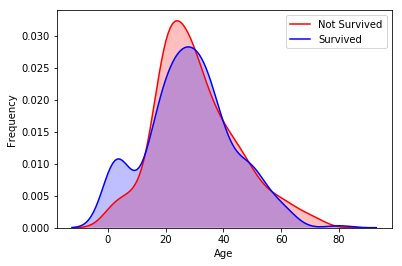

In [69]:
# Explore Age distibution 
g = sns.kdeplot(dataset["Age"][(dataset["Survived"] == 0) & (dataset["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(dataset["Age"][(dataset["Survived"] == 1) & (dataset["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

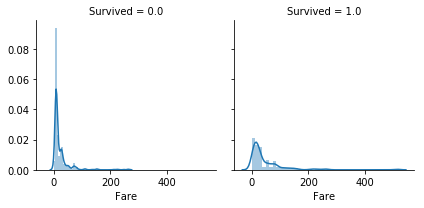

In [70]:
g = sns.FacetGrid(dataset, col='Survived')
g = g.map(sns.distplot, "Fare")

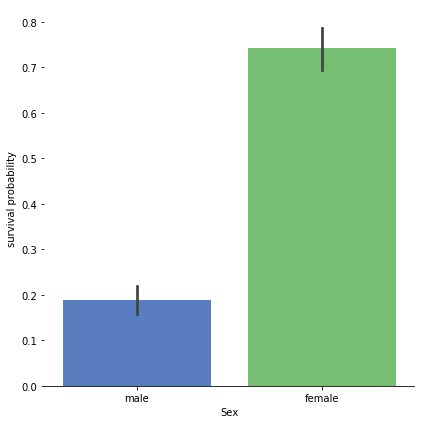

In [71]:
g = sns.factorplot(x="Sex",y="Survived",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

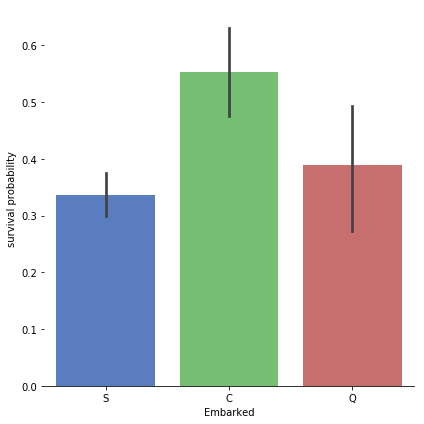

In [72]:
g = sns.factorplot(x="Embarked",y="Survived",data=dataset,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Data engineering is another key trick in Machine Learning. We generally want to convert all our data from categorical to numerical of some sort. 

## Data Augmentation

In [5]:
dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


We can see that age cabin and embarked have missing  values. Name needs to be augemented, to perhaps just keep the title. The sex need to be encoded. SipSp and Parch can be combined. Ticket can be dropped. Cabin can be a has a cabin or not type of structure.

In [7]:
def cabin_checker(value):
    if type(value) == float:
        return 0
    else:
        return 1  
    
def age_mapper(value):
    if 0 < value < 14:
        return 'child'
    elif 13 < value < 19:
        return 'teenager'
    elif 18 < value < 65:
        return 'adult'
    else:
        return 'senior'
    
    

scaler = MinMaxScaler()


#fill in missing
dataset['Embarked'] = dataset['Embarked'].fillna('S')
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())
    
#augment data
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"]
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)
dataset["Sex"] = dataset["Sex"].map({'female':0, 'male':1}).astype(int)
dataset["has_cabin"] = dataset["Cabin"].apply(cabin_checker)
dataset["Age_cl"] = dataset["Age"].apply(age_mapper)
    
import re

# Create new feature IsAlone from FamilySize

dataset['IsAlone'] = 0
dataset.loc[dataset['Fsize'] == 1, 'IsAlone'] = 1

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Create a new feature Title, containing the titles of passenger names
dataset['Title'] = dataset['Name'].apply(get_title)
    
# Group all non-common titles into one single grouping "Rare"

dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 
                                                 'Sir', 'Jonkheer', 'Dona'], 'Rare')

dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')


# Mapping titles
dataset['Title'] = dataset['Title'].fillna(0)
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
dataset['Title'] = dataset['Title'].map(title_mapping)
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

#dhe
    

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket    

In [10]:
dataset.T

,0,1,2,3,4,5,6,7,8,9,...,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308
Age,22,38,26,35,35,28,54,2,27,14,...,28,3,28,37,28,28,39,38.5,28,28
Cabin,X,C,X,C,X,X,E,X,X,X,...,X,X,X,C,X,X,C,X,X,X
Embarked,S,C,S,S,S,Q,S,S,S,C,...,Q,S,Q,Q,S,S,C,S,S,C
Fare,1.981,4.26666,2.07002,3.97218,2.08567,2.13515,3.9486,3.04809,2.40994,3.40355,...,2.04392,2.62286,2.04769,4.49981,2.05091,2.08567,4.69043,1.981,2.08567,3.1072
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry","Moran, Mr. James","McCarthy, Mr. Timothy J","Palsson, Master. Gosta Leonard","Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)","Nasser, Mrs. Nicholas (Adele Achem)",...,"Riordan, Miss. Johanna Hannah""""","Peacock, Miss. Treasteall","Naughton, Miss. Hannah","Minahan, Mrs. William Edward (Lillian E Thorpe)","Henriksson, Miss. Jenny Lovisa","Spector, Mr. Woolf","Oliva y Ocana, Dona. Fermina","Saether, Mr. Simon Sivertsen","Ware, Mr. Frederick","Peter, Master. Michael J"
Parch,0,0,0,0,0,0,0,1,2,0,...,0,1,0,0,0,0,0,0,0,1
PassengerId,1,2,3,4,5,6,7,8,9,10,...,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309
Pclass,3,1,3,1,3,3,1,3,3,2,...,3,3,3,1,3,3,1,3,3,3
Sex,1,0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,1,0,1,1,1
SibSp,1,1,0,1,0,0,0,3,0,1,...,0,1,0,1,0,0,0,0,0,1


In [11]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")
dataset = pd.get_dummies(dataset, columns = ["Age_cl"])
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

dataset.T

,0,1,2,3,4,5,6,7,8,9,...,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308
Age,22,38,26,35,35,28,54,2,27,14,...,28,3,28,37,28,28,39,38.5,28,28
Fare,1.981,4.26666,2.07002,3.97218,2.08567,2.13515,3.9486,3.04809,2.40994,3.40355,...,2.04392,2.62286,2.04769,4.49981,2.05091,2.08567,4.69043,1.981,2.08567,3.1072
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry","Moran, Mr. James","McCarthy, Mr. Timothy J","Palsson, Master. Gosta Leonard","Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)","Nasser, Mrs. Nicholas (Adele Achem)",...,"Riordan, Miss. Johanna Hannah""""","Peacock, Miss. Treasteall","Naughton, Miss. Hannah","Minahan, Mrs. William Edward (Lillian E Thorpe)","Henriksson, Miss. Jenny Lovisa","Spector, Mr. Woolf","Oliva y Ocana, Dona. Fermina","Saether, Mr. Simon Sivertsen","Ware, Mr. Frederick","Peter, Master. Michael J"
Parch,0,0,0,0,0,0,0,1,2,0,...,0,1,0,0,0,0,0,0,0,1
PassengerId,1,2,3,4,5,6,7,8,9,10,...,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309
Sex,1,0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,1,0,1,1,1
SibSp,1,1,0,1,0,0,0,3,0,1,...,0,1,0,1,0,0,0,0,0,1
Survived,0,1,1,1,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fsize,1,1,0,1,0,0,0,4,2,1,...,0,2,0,1,0,0,0,0,0,2
Single,1,1,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [78]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 76 columns):
Age                1309 non-null float64
Fare               1309 non-null float64
Name               1309 non-null object
Parch              1309 non-null int64
PassengerId        1309 non-null int64
Sex                1309 non-null int64
SibSp              1309 non-null int64
Survived           891 non-null float64
Fsize              1309 non-null int64
Single             1309 non-null int64
SmallF             1309 non-null int64
MedF               1309 non-null int64
LargeF             1309 non-null int64
has_cabin          1309 non-null int64
IsAlone            1309 non-null int64
T_A                1309 non-null uint8
T_A4               1309 non-null uint8
T_A5               1309 non-null uint8
T_AQ3              1309 non-null uint8
T_AQ4              1309 non-null uint8
T_AS               1309 non-null uint8
T_C                1309 non-null uint8
T_CA               1309 non-n

In [79]:
drop_elements = ['Name', 'SibSp', 'Parch']

dataset = dataset.drop(drop_elements, axis = 1)

In [80]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [81]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

In [82]:
dataset["Fare"] = scale.fit_transform(dataset["Fare"].reshape(-1,1))
dataset["Age"] = scale.fit_transform(dataset["Age"].reshape(-1,1))
dataset.head()

,Age,Fare,PassengerId,Sex,Survived,Fsize,Single,SmallF,MedF,LargeF,...,Age_cl_teenager,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,-0.581628,-0.921196,1,1,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.658652,1.349258,2,0,1.0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,-0.271558,-0.832767,3,0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.426099,1.056732,4,0,1.0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.426099,-0.817221,5,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Modelling 

First we make a copy of our dataset just in case we need to use it again later

In [83]:
c_dataset = dataset.copy()
c_dataset.head()

,Age,Fare,PassengerId,Sex,Survived,Fsize,Single,SmallF,MedF,LargeF,...,Age_cl_teenager,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,-0.581628,-0.921196,1,1,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.658652,1.349258,2,0,1.0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,-0.271558,-0.832767,3,0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.426099,1.056732,4,0,1.0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.426099,-0.817221,5,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [84]:
dataset = c_dataset

Here, we are making two classes to use for our OOF predictions

In [85]:
from sklearn.cross_validation import KFold

# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

Rejoin the data and then make your different test sets

In [86]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

## Separate train features and label 

#train["Survived"] = train["Survived"].astype(int)

#Y_train = train["Survived"]

#X_train = train.drop(labels = ["Survived"],axis = 1)


# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

In [87]:
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})


cv_res.sort_values(by='CrossValMeans', ascending=False)

,Algorithm,CrossValMeans,CrossValerrors
5,GradientBoosting,0.821645,0.034850
9,LinearDiscriminantAnalysis,0.821632,0.037364
8,LogisticRegression,0.819347,0.028400
3,RandomForest,0.814852,0.035359
4,ExtraTrees,0.805901,0.037237
2,AdaBoost,0.770108,0.052833
1,DecisionTree,0.755525,0.062048
6,MultipleLayerPerceptron,0.708308,0.056567
0,SVC,0.512862,0.087407
7,KNeighboors,0.453461,0.090878


Here are the different models: Random Forest, Extra Trees, AdaBoost, Gradient Boosting and SVM were used.

In [88]:
kfold = StratifiedKFold(n_splits=10)

# Random Forest parameters
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1,8,10, 50],
              "min_samples_split": [3, 5, 10,30],
              "min_samples_leaf": [1,5,10,50],
              "bootstrap": [False],
              "n_estimators" :[200,500, 1000],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsRFC.fit(x_train,y_train)
RFC_best = gsRFC.best_estimator_

# params found
rf_param = {"max_depth": RFC_best.max_depth,
              "max_features": RFC_best.max_features,
              "min_samples_split": RFC_best.min_samples_split,
              "min_samples_leaf": RFC_best.min_samples_leaf,
              "bootstrap": RFC_best.bootstrap,
              "n_estimators": RFC_best.n_estimators,
              "criterion": RFC_best.criterion}


rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_param)
gsRFC.best_score_

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  4.3min finished


0.8428731762065096

In [89]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()

# Extra Trees Parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [5, 20, 40, 60],
              "min_samples_split": [10, 50, 70, 90],
              "min_samples_leaf": [2, 6, 8, 10, 50],
              "bootstrap": [False],
              "n_estimators" : [200, 300, 1000],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsExtC.fit(x_train,y_train)
ExtC_best = gsExtC.best_estimator_

ex_param = {"max_depth": ExtC_best.max_depth,
              "max_features": ExtC_best.max_features,
              "min_samples_split": ExtC_best.min_samples_split,
              "min_samples_leaf": ExtC_best.min_samples_leaf,
              "bootstrap": ExtC_best.bootstrap,
              "n_estimators" : ExtC_best.n_estimators,
              "criterion": ExtC_best.criterion}



et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=ex_param)
gsExtC.best_score_

Fitting 10 folds for each of 240 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  4.2min finished


0.8372615039281706

In [90]:
AdaC = AdaBoostClassifier()

# AdaBoost parameters
ada_param_grid = {
    'n_estimators': [10, 50,80,100,150],
    'learning_rate': [0.1,0.3,0.5]}

gsAdaC = GridSearchCV(AdaC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsAdaC.fit(x_train,y_train)
gsAdaC_best = gsAdaC.best_estimator_


ada_params = {
    'n_estimators': gsAdaC_best.n_estimators,
    'learning_rate': gsAdaC_best.learning_rate
}
                        
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gsAdaC.best_score_

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.4s finished


0.8249158249158249

In [91]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [200, 400, 1000, 2000],
              'learning_rate': [0.01, 0.1, 0.5, 1],
              'max_depth': [1, 5, 10, 50, 70],
              'min_samples_leaf': [1, 10, 50, 100],
              'max_features': [0.1, 0.5, 1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsGBC.fit(x_train,y_train)
GBC_best = gsGBC.best_estimator_

gb_param = {'loss' : GBC_best.loss,
              'n_estimators' : GBC_best.n_estimators,
              'learning_rate': GBC_best.learning_rate,
              'max_depth': GBC_best.max_depth,
              'min_samples_leaf': GBC_best.min_samples_leaf,
              'max_features': GBC_best.max_features 
              }

gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_param)
gsGBC.best_score_

Fitting 10 folds for each of 960 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 570 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 920 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1370 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1920 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2570 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 3320 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 4170 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 5120 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 6170 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 7320 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 8570 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed: 16.1min finished


0.8383838383838383

In [92]:
#Logistic Regression

LRC = LogisticRegression()
lr_param_grid = {'C':[0.001,0.01,0.1,1,10,100],
                 'class_weight': [None, 'balanced'],
                 'tol':[0.0001,0.01,0.1],
                 'max_iter':[10,100,500]                           
}

gsLRC = GridSearchCV(LRC,param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsLRC.fit(x_train,y_train)
LRC_best = gsLRC.best_estimator_

lr_param_grid = {'C':LRC_best.C,
                 'tol':LRC_best.tol,
                 'max_iter':LRC_best.max_iter, 
                 'class_weight': LRC_best.class_weight
}

lr = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lr_param_grid)
gsLRC.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:    6.0s finished


0.8249158249158249

In [122]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best),('lrc', LRC_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(x_train, y_train)

In [123]:
y_train_pred = cross_val_predict(votingC, x_train, y_train, cv=kfold)

In [124]:
roc_auc_score(y_train, y_train_pred)

0.8104927619595437

In [125]:
f1_score(y_train, y_train_pred)

0.766412213740458

In [100]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived.astype(int)],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)

In [98]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null int64
dtypes: int64(2)
memory usage: 6.6 KB


In [39]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
lr_oof_train, lr_oof_test = get_oof(lr, x_train, y_train, x_test) #Logstic Regression

print("Training is complete")

Training is complete


In [40]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel(),
        'LogisticReg' : lr_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,LogisticReg,RandomForest
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0


## Checking Correlation of Different Models

In [41]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [42]:
x_train = np.concatenate(( rf_oof_train,  lr_oof_train, et_oof_train, ada_oof_train, gb_oof_train), axis=1) 
x_test = np.concatenate(( rf_oof_test, lr_oof_test,et_oof_test, ada_oof_test, gb_oof_test), axis=1)

## XGBoost for Second Level Modeling

In [45]:
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

xbgC = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=1)


xbg_grid = {
    'n_estimators':[500, 1000, 2000, 4000],
     'max_depth':[3, 4, 5],
     'min_child_weight':[1, 5, 10],
     'gamma': [0.5, 1, 1.5, 2, 5],                        
     'subsample':[0.6, 0.8, 1.0],
     'colsample_bytree':[0.6, 0.8, 1.0],  
}

gsxbgC = GridSearchCV(xbgC, param_grid = xbg_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsxbgC.fit(x_train, y_train)
xbg_best = gsxbgC.best_estimator_
print(gsxbgC.best_score_)



Fitting 10 folds for each of 1620 candidates, totalling 16200 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 594 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 1091 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1705 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2468 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3369 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4421 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5433 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 6480 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 7678 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 8983 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 10341 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 11751 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 13254 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 14804 tasks      | elapsed:

0.8282828282828283


In [46]:
xbg_best

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=2, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=4000,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [49]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(xbg_best, x_train, y_train, cv=kfold)

In [50]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[498,  51],
       [102, 240]])

In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train, y_train_pred)

0.8247422680412371

In [52]:
recall_score(y_train, y_train_pred)

0.7017543859649122

In [53]:
f1_score(y_train, y_train_pred)

0.7582938388625592

In [54]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_train_pred)

0.8044291055507621

## Submission

In [47]:
predictions = gsxbgC.predict(x_test)

# Generate Submission File 
submission = pd.DataFrame({
        "PassengerId": IDtest,
        "Survived": predictions.astype(int)
    })
submission.to_csv("Accuracy.csv", index=False)